# Interpolacja Hermite'a 
## Używając metody Newtona oraz pierwszej pochodnej

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
from collections.abc import Callable
import ipympl
%matplotlib ipympl

## Generowanie węzłów interpolacji

In [2]:
def generate_chebyshev_roots(n: int, a: np.float64, b: np.float64):
  return np.array([(a+b)/2 + (b-a)/2 * np.cos((2*k+1)/(2*n) * np.pi) for k  in range(n)], dtype=np.float64)

def generate_function_uniform_nodes(n: int, interval: tuple[np.float64, np.float64], func):
  a,b= interval[0], interval[1]
  xs = np.linspace(a,b,n)
  tups = []
  for x in xs:
    tups.append((x,func(x)))
  return np.array(tups)

def generate_function_chebyshev_nodes(n: int, interval: tuple[np.float64, np.float64], func):
  a,b= interval[0], interval[1]
  xs = generate_chebyshev_roots(n,a,b)
  tups = []
  for x in xs:
    tups.append((x,func(x)))
  return np.array(tups)


## Interpolacja Hermite'a

In [3]:
def hermite_divided_difference_table(nodes: np.ndarray, deriv_nodes: np.ndarray) -> np.ndarray:

  n = len(nodes)
  nodes_x = nodes[:,0]
  nodes_y = nodes[:,1]
  nodes_derivative_y = deriv_nodes[:,1]
  z = np.zeros(2 * n, dtype=np.float64) # Duplicate values for Hermite interpolation
  dp = np.zeros((2 * n, 2 * n), dtype=np.float64)  # Divided difference table

  # Fill z with duplicated x values
  for i in range(n):
    z[2 * i] = nodes_x[i]
    z[2 * i + 1] = nodes_x[i]

  # Fill in function values
  for i in range(n):
    dp[2 * i, 0] = nodes_y[i]
    dp[2 * i + 1, 0] = nodes_y[i]
    dp[2 * i + 1, 1] = nodes_derivative_y[i]  # First derivative constraint
    if i != 0:
      dp[2 * i, 1] = (dp[2 * i, 0] - dp[2 * i - 1, 0]) / (z[2 * i] - z[2 * i - 1])


  for i in range(2,2*n):
    for j in range(2,i+1):
      dp[i,j] = (dp[i,j-1] - dp[i-1,j-1])/(z[i] - z[i-j])

  return z, dp


def get_hermite_interpolation_func(nodes: np.ndarray, deriv_nodes: np.ndarray) -> Callable[[float], float]:
    
    nodes_x, dp = hermite_divided_difference_table(nodes, deriv_nodes)
    
    def func_hermite(x: float) -> float:
      # n = len(nodes_x)
      # result = dp[0,n-1]
      # for i in range(n-2,-1,-1):
      #   result = result * (x-nodes_x[i]) + dp[0,i]
      # return result
      
      n = len(nodes_x)
      result = dp[n - 1, n - 1]
      for i in range(n - 2, -1, -1):
        result = result * (x - nodes_x[i]) + dp[i, i]
      return result
      
      # result = dp[0, 0]  # a0
      # product_term = 1.0
      # for i in range(1, len(nodes_x)):
      #   product_term *= (x - nodes_x[i - 1])
      #   result += dp[i, i] * product_term
      # return result

    
    return func_hermite

## Błąd Pomiarowy

In [4]:
NUMBER_OF_PROBES = 1000

def get_max_error(func, interpolation_func, interval):
  xs = np.linspace(interval[0], interval[1], NUMBER_OF_PROBES)
  return max([np.abs(func(x) - interpolation_func(x)) for x in xs])

def get_squared_error(func, interpolation_func, interval):
  xs = np.linspace(interval[0], interval[1], NUMBER_OF_PROBES)
  return np.sqrt(sum([(func(x) - interpolation_func(x))**2 for x in xs])) / NUMBER_OF_PROBES


## Wizualizacja

In [5]:
def plot_function(
    x_values: np.ndarray[np.float64], 
    func: Callable[[np.float64], np.float64], 
    nodes: np.ndarray[(np.float64, np.float64)] | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: tuple[float, float] | None = None,
    x_scale: str = 'linear',
    y_scale: str = 'linear',
    function_name: str = 'Funkcja bazowa',
    nodes_name: str = 'Węzły interpolacji'
):
    y_values = np.array([func(x) for x in x_values])

    plt.plot(x_values, y_values, label=function_name)
    if nodes is not None:
        plt.scatter(nodes[:, 0], nodes[:, 1], color='red', label=nodes_name)
    
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Wizualizacja funkcji')

## Przykładowe użycie

In [6]:
m = 5
k = 0.5
interval = (-5,5)
N = 11

func = lambda x: x**2 - m*np.cos((np.pi * x) / k)
func_derivative = lambda x: 2*x + ((m * np.pi) / k) * np.sin((np.pi * x) / k) 

In [7]:
nodes_linear = generate_function_uniform_nodes(N,interval, func)
nodes_derivative_linear = generate_function_uniform_nodes(N,interval, func_derivative)

hermite_linear = get_hermite_interpolation_func(nodes_linear, nodes_derivative_linear)

nodes_chebyshev = generate_function_chebyshev_nodes(N,interval, func)
nodes_derivative_chebyshev= generate_function_chebyshev_nodes(N,interval, func_derivative)

hermite_chebyshev= get_hermite_interpolation_func(nodes_chebyshev, nodes_derivative_chebyshev)


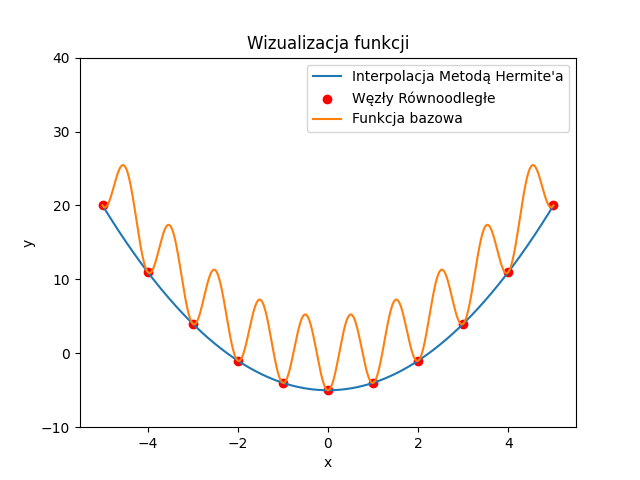

In [8]:
plt.clf()
plot_function(np.linspace(interval[0], interval[1], 1000), hermite_linear, nodes_linear, y_lim=(-10,40), function_name='Interpolacja Metodą Hermite\'a', nodes_name='Węzły Równoodległe')
plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
plt.show()

# plt.clf()
# plot_function(np.linspace(interval[0], interval[1], 1000), hermite_chebyshev, nodes_chebyshev, y_lim=(-10,40), function_name='Interpolacja Metodą Hermite\'a', nodes_name='Węzły Czebyszewa')
# plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
# plt.show()

In [ ]:
PATH_TO_SAVE_MAIN = os.path.join('.', 'img')
PATH_TO_SAVE_LINEAR = os.path.join(PATH_TO_SAVE_MAIN, 'linear')
PATH_TO_SAVE_CHEBYSHEV = os.path.join(PATH_TO_SAVE_MAIN, 'chebyshev')
PATH_TO_SAVE_DATA = os.path.join('.', 'data')

if(os.path.exists(PATH_TO_SAVE_MAIN)):
  shutil.rmtree(PATH_TO_SAVE_MAIN)

os.makedirs(PATH_TO_SAVE_DATA, exist_ok=True)

# Initialize a list to store data for the CSV
data_records = []

# Declare max number of nodes
N = 51

for i in range(1, N):
  nodes_linear = generate_function_uniform_nodes(i, interval, func)
  nodes_derivative_linear = generate_function_uniform_nodes(i,interval, func_derivative)
  nodes_chebyshev = generate_function_chebyshev_nodes(i, interval, func)
  nodes_derivative_chebyshev = generate_function_chebyshev_nodes(i, interval, func_derivative)
  interpolation_linear = get_hermite_interpolation_func(nodes_linear, nodes_derivative_linear)
  interpolation_chebyshev = get_hermite_interpolation_func(nodes_chebyshev, nodes_derivative_chebyshev)

  error_max_linear = get_max_error(func, interpolation_linear, interval)
  error_squared_linear = get_squared_error(func, interpolation_linear, interval)
  error_max_chebyshev = get_max_error(func, interpolation_chebyshev, interval)
  error_squared_chebyshev = get_squared_error(func, interpolation_chebyshev, interval)

  # Save plots for linear nodes
  plot_function(np.linspace(interval[0], interval[1], 1000), interpolation_linear, nodes_linear, y_lim=(-10, 40), nodes_name='Węzły Równoodległe', function_name='Interpolacja Metodą Hermite\'a')
  plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10, 40))
  os.makedirs(PATH_TO_SAVE_LINEAR, exist_ok=True)
  plt.savefig(os.path.join(PATH_TO_SAVE_LINEAR, f'Interpolacja Metodą Hermite\'a Węzły Liniowe i={i}'))
  plt.clf()

  # # Save plots for Chebyshev nodes
  os.makedirs(PATH_TO_SAVE_CHEBYSHEV, exist_ok=True)
  plot_function(np.linspace(interval[0], interval[1], 1000), interpolation_chebyshev, nodes_chebyshev, y_lim=(-10, 40), nodes_name='Węzły Czebyszewa', function_name='Interpolacja Metodą Hermite\'a')
  plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10, 40))
  plt.savefig(os.path.join(PATH_TO_SAVE_CHEBYSHEV, f'Interpolacja Metodą Hermite\'a Węzły Czebyszewa i={i}'))
  plt.clf()

  # Append data for CSV
  data_records.append({
    'Number of Nodes': i,
    'Node Type': 'Linear',
    'Max Error': error_max_linear,
    'Squared Error': error_squared_linear
  })
  data_records.append({
    'Number of Nodes': i,
    'Node Type': 'Chebyshev',
    'Max Error': error_max_chebyshev,
    'Squared Error': error_squared_chebyshev
  })
  
  def format_float(value):
    try:
      num = float(value)
      if abs(num) >= 1e6 or abs(num) < 1e-3:  # Use scientific notation for very large/small numbers
        return f'{num:.6e}'  # 6 digits, exponential format
      else:
        return f'{num:.6f}'  # 6 digits, fixed-point
    except:
      return value  # If it's not a float, leave as is

# Assume data_records is already populated
df = pd.DataFrame(data_records)

# Format relevant float columns
float_columns = ['Max Error', 'Squared Error']
for col in float_columns:
  df[col] = df[col].apply(format_float)

# Save to CSV
df.to_csv(
  os.path.join(PATH_TO_SAVE_DATA, 'interpolation_errors.csv'),
  index=False
)